# Plots for the node weights
This is the file used to analyze and visualize runlogs generated by the training

In [16]:
from suppl import *
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

hist_dir = './history/'
imgs_dir = './images/'
city_dir = '../cities/'

city_file = 'test_5_intersection.html'

hist_file_names = [
    'history_agent_gcnn_2023-05-03_23-33_test_5_intersection.csv',
    'history_agent_enn_2023-05-04_12-37_test_5_intersection.csv',
    'history_agent_snn_2023-05-04_14-28_test_5_intersection.csv'
]

hist_file_names = [
    'history_agent_gcnn_2023-05-01_14-21_test_5_intersection_empty.csv',
    'history_agent_enn_2023-05-04_22-59_test_5_intersection_empty.csv',
    'history_agent_snn_2023-05-04_20-30_test_5_intersection_empty.csv'
]

out_name = 'node_weights_plot_test_5_intersection_empty'
model_names = ['Graph convolutional', 'Embedding based', 'Feature based']

### Read points 

In [17]:
df_city = pd.read_html(city_dir + city_file)[0]

df_city.set_index('Name', drop=True, inplace=True)
df_city.sort_values(by=['Name'], inplace=True)
ind = ['Point' in x for x in list(df_city.index)]

df_points = df_city.loc[ind].dropna(axis=1)  # Name, (x, y)
df_segments = df_city.loc[[not x for x in ind]].reset_index().drop('Name', axis=1)

# Process points
df_points.index = [x.split(' ')[1] for x in list(df_points.index)]  # Get only letter
df_points['Value'] = [re.findall(r'[\d.]+', x) for x in df_points['Value']]  # Find coordinates
df_points['Value'] = [tuple([float(x) for x in lst]) for lst in df_points['Value']]  # Convert coords to float
points = {letter_to_number(x): y for x, y in zip(list(df_points.index), df_points['Value'])}  # {ID: (x, y), ...}

### Read logs

In [18]:
df_logs_conv = []
for hist_file in hist_file_names:
    df_logs = pd.read_csv(hist_dir + hist_file, sep='\t')
    df_logs_g = pd.DataFrame(df_logs.groupby(by='end').sum().loc[:, 'reward'])
    df_logs_g['x'] = [points[x][0] for x in df_logs_g.index]
    df_logs_g['y'] = [points[x][1] for x in df_logs_g.index]
    df_logs_conv.append(df_logs_g)

display(df_logs_conv[0].head())

,reward,x,y
end,,,
0.0,60072701.0,74.23,80.31
1.0,276494210.0,189.02,248.52
2.0,62051253.0,350.00,100.00
3.0,287646199.0,323.75,377.66
4.0,263991524.0,82.20,405.56


Saving figure node_reward_plot_node_weights_plot_test_5_intersection_empty


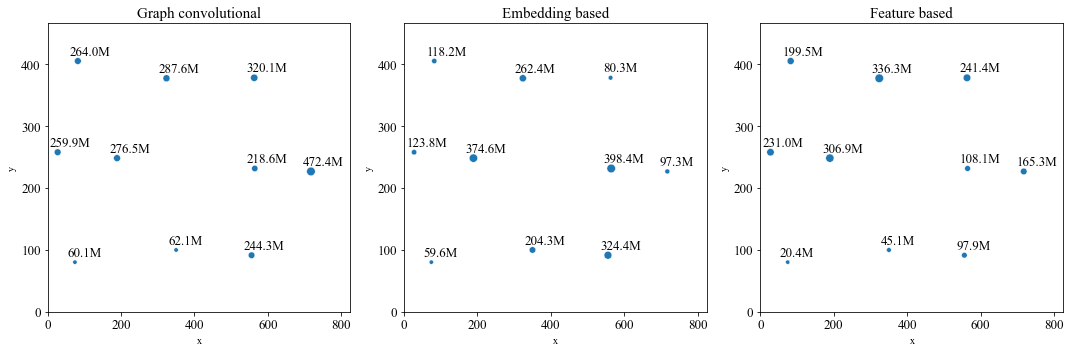

In [19]:
plt.figure(figsize=(15, 5))
for i in range(len(df_logs_conv)): 
    plt.subplot(1, 3, i+1)
    df_logs_g = df_logs_conv[i]
    plt.title(model_names[i], size=15)
    plt.tick_params(axis='both', which='major', labelsize=13)
    sns.scatterplot(data=df_logs_g, x='x', y='y', size='reward')
    plt.xlim([0, max(df_logs_g.x) * 1.15])
    plt.ylim([0, max(df_logs_g.y) * 1.15])
    plt.legend().remove()
    for i in range(len(df_logs_g)):
        rec = df_logs_g.iloc[i, :]
        plt.text(rec.x - 21, rec.y + 10, f'{round(rec.reward / 1e6, 1)}M', size=13)
save_fig(f'node_reward_plot_{out_name}')
plt.show()

In [20]:
list(range(len(df_logs_conv)))

[0, 1, 2]